
# Thematische Analyse von Verbraucherbeschwerden mittels NLP

# Einleitung

Das Consumer Financial Protection Bureau (CFPB) sammelt Verbraucherbeschwerden zu Finanzdienstleistungen in den USA.  
Diese Beschwerden liegen als unstrukturierte Texte vor und decken ein breites Spektrum ab – von Kreditkartenproblemen über Hypotheken bis hin zu Betrugsfällen.

Aufgrund der großen Datenmenge ist eine manuelle Analyse ineffizient.  
Ziel dieser Arbeit ist es daher, **Natural Language Processing (NLP)**-Techniken einzusetzen, um die Beschwerdetexte systematisch zu strukturieren und zentrale Themen automatisch zu identifizieren.


# Ziel der Arbeit

Die Analyse soll Entscheidungsträger:innen dabei unterstützen, einen Überblick über häufige und dringende Verbraucherprobleme zu gewinnen.  
Dadurch können Strategien entwickelt werden, um Servicequalität und Verbraucherschutz gezielt zu verbessern.


# Datenquelle

Für die Untersuchung wird der öffentlich verfügbare Datensatz 
**"Consumer Complaints Dataset for NLP"** von Kaggle genutzt:

[ https://www.kaggle.com/datasets/shashwatwork/consume-complaints-datasetfo-nlp](https://www.kaggle.com/datasets/shashwatwork/consume-complaints-dataset-fo-nlp)


Der Datensatz enthält tausende Einträge mit Beschwerdetexten, Produkten, Unternehmen und Zeitangaben.  
Im Fokus stehen hier ausschließlich die textuellen Beschreibungen der Beschwerden.

# 1) Voraussetzungen & Installation

- Es wird empfohlen, eine **virtuelle Umgebung** (`venv`) zu verwenden.  
  Beispiel (Terminal):

  python -m venv .venv
  source .venv/bin/python # unter Linux (WSL2)

- Alle benötigten Abhängigkeiten werden in einer `requirements.txt` abgelegt. 

In [1]:
import os

# Die Datei requirements.txt wird nur erzeugt, falls sie nicht existiert.
# Soll die Datei neu erzeugt werden, so muss die vorhandene vor dem Ausführen gelöscht werden.

if not os.path.exists("requirements.txt"):
    requirements = """\
# Basis
numpy>=1.26.0
pandas>=2.1.0
matplotlib>=3.8.0
seaborn>=0.13.0
tabulate

# NLP & Modellierung
scikit-learn>=1.4.0
nltk>=3.8.1
spacy>=3.7.0
gensim>=4.3.2

# Fortschrittsanzeige
tqdm>=4.66.1
"""
    with open("requirements.txt", "w", encoding="utf-8") as f:
        f.write(requirements.strip() + "\n")
    print("✅ requirements.txt wurde neu erstellt.")
else:
    print("⚠️ requirements.txt existiert bereits. Nichts geändert.")


⚠️ requirements.txt existiert bereits. Nichts geändert.


# Installation der benötigten Abhängigkeiten

In das jeweilige Ausführungsverzeichnis wechseln und folgenden Befehl ausführen.

".venv/bin/python -m pip install -r requirements.txt"

In [2]:
# Abhängigkeiten importieren

import glob
import pandas as pd

# NLP-Tools
import re
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

# Für Sprache Englisch
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stopwords

# Dictionaries
from collections import Counter

# ML-Tools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

#gensim für Kohärenzbewertung
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Hinweis:

Falls nach der Installation eventuell packages fehlen (ModuleNotFoundError), diese per ".venv/bin/python -m pip install *packagename-1 packagename-2 ... packagename-n*"
installieren. 
Auf diese Weise werden die Pakete in der virtuellen Umgebung für das Projekt installiert (/.venv/lib/python3.11/site-packages/). 

Installiert man die Pakete per "python -m pip install *packagename-1 packagename-2 ... packagename-n*", 
so werden die Pakete **global** im lokalen Benutzerverzeichnis installiert (~/.local/lib/python3.11/site-packages).
Dies kann projektübergreifend zu Problemen führen.

# 2) Daten einlesen & Textspalte finden

In [3]:
# Suche nach CSV-Dateien im archive/-Ordner (nach Kaggle-Download)
csvs = glob.glob(os.path.join('archive', '*.csv'))
if not csvs:
    print("Keine CSV-Datei unter archive/ gefunden. Bitte lade den Kaggle-Datensatz herunter und entpacke ihn nach ./archive/")
else:
    print('Gefundene CSV-Dateien:', csvs)
    df = pd.read_csv(csvs[0], low_memory=False)
    print('\nSpalten im Datensatz:')
    print(df.columns.tolist())

Gefundene CSV-Dateien: ['archive/complaints_processed.csv']

Spalten im Datensatz:
['Unnamed: 0', 'product', 'narrative']


Textspalte, die **wahrscheinlich** die Beschwerdetexte enthält, wählen.
Nach Spaltennamen, die typische Begriffe wie 'narrative', 'complaint', 'consumer' enthalten, suchen.

In [4]:
# Automatische Textspalte finden
text_col = None
if 'df' in globals():
    cols = df.columns.tolist()
    candidates = [c for c in cols if any(k in c.lower() for k in ['narrative', 'complaint', 'consumer'])]
    if candidates:
        text_col = candidates[0]
        print(f"Ausgewählte Textspalte: {text_col}")
    else:
        print("Keine offensichtliche Textspalte gefunden. Bitte manuell wählen.")
        display(df.head())

Ausgewählte Textspalte: narrative


# 3) Datenvorverarbeitung

Da es sich um unstrukturierte Texte handelt, ist eine systematische Bereinigung erforderlich.  
Die wichtigsten Schritte der Textaufbereitung sind:

1. Entfernung von Sonderzeichen, überflüssigen Leerzeichen und Steuerzeichen.
2. Vereinheitlichung der Groß- und Kleinschreibung.
3. Tokenisierung in Wörter oder Subwörter.
4. Entfernung von Stopwords, um irrelevante Begriffe zu reduzieren.
5. Lemmatisierung zur Zusammenführung verschiedener Wortformen.
6. Entfernung von Duplikaten.

Das Ergebnis dieses Prozesses sind **saubere, standardisierte Texte**, die sich für die anschließende numerische und semantische Analyse eignen.

In [5]:
try:
    nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
except Exception as e:
    print('SpaCy Modell en_core_web_sm nicht gefunden. Bitte ausführen: .venv/bin/python -m spacy download en_core_web_sm')
    raise

stop_words = set(stopwords.words('english')) | spacy_stopwords

def preprocess_text(text, nlp=nlp, stop_words=stop_words, min_token_len=3):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)  # URLs entfernen
    text = re.sub(r'\s+', ' ', text).strip()
    if not text:
        return ''
    doc = nlp(text)
    tokens = []
    for token in doc:
        lemma = token.lemma_.strip()
        if len(lemma) < min_token_len:
            continue
        if lemma in stop_words:
            continue
        if token.is_punct or token.is_space:
            continue
        tokens.append(lemma)
    return ' '.join(tokens)

In [6]:
# Beispiel: Vorverarbeitung auf eine kleine Auswahl testen (noch nicht auf kompletten Datensatz laufen lassen)
if 'df' in globals() and text_col:
    sample = df[text_col].dropna().astype(str).head(10)
for s in sample:
    print('--- ORIGINAL ---')
    print(s[:200])
    print('\n--- VORVERARBEITET ---')
    print(preprocess_text(s)[:200])
    print('\n')

--- ORIGINAL ---
purchase order day shipping amount receive product week sent followup email exact verbiage paid two day shipping received order company responded im sorry inform due unusually high order volume order 

--- VORVERARBEITET ---
purchase order day shipping receive product week send followup email exact verbiage pay day shipping receive order company respond sorry inform unusually high order volume order ship week stock early 


--- ORIGINAL ---
forwarded message date tue subject please investigate comenity bank retailer card scam sent hello name scammed comenity bank credit card provider company childrens place new york forever victoria secr

--- VORVERARBEITET ---
forward message date tue subject investigate comenity bank retailer card scam send hello scamme comenity bank credit card provider company children place new york forever victoria secret original cred


--- ORIGINAL ---
forwarded message cc sent friday pdt subject final legal payment well fargo well fargo clearl

In [7]:
# Vollständige Vorverarbeitung (kann je nach Datensatz lange dauern)
if 'df' in globals() and text_col:
    # Vor Duplikaten entfernen: NaNs entfernen
    df = df.dropna(subset=[text_col])
    # Duplikate entfernen (auf Originaltextspalte)
    df = df.drop_duplicates(subset=[text_col])
    texts = df[text_col].astype(str)
    cleaned = []
    for t in tqdm(texts, desc='Vorverarbeitung'):
        cleaned.append(preprocess_text(t))
    df['cleaned_text'] = cleaned
    print('Vorverarbeitung abgeschlossen. Spalte: cleaned_text')

Vorverarbeitung: 100%|██████████| 124472/124472 [05:20<00:00, 388.63it/s]

Vorverarbeitung abgeschlossen. Spalte: cleaned_text


# 4) Transformation in numerische Vektoren

Zur weiteren Analyse werden die Texte in numerische Repräsentationen überführt.  
Dies ermöglicht den Einsatz von Clustering- und Themenmodellierungsverfahren.

Für diese Arbeit werden zwei Ansätze genutzt:

- **CountVectorizer** – einfache Wortzählung (Bag-of-Words)
- **TF-IDF-Vektorisierung** – gewichtete Repräsentation, die seltene, aber bedeutungsvolle Begriffe hervorhebt


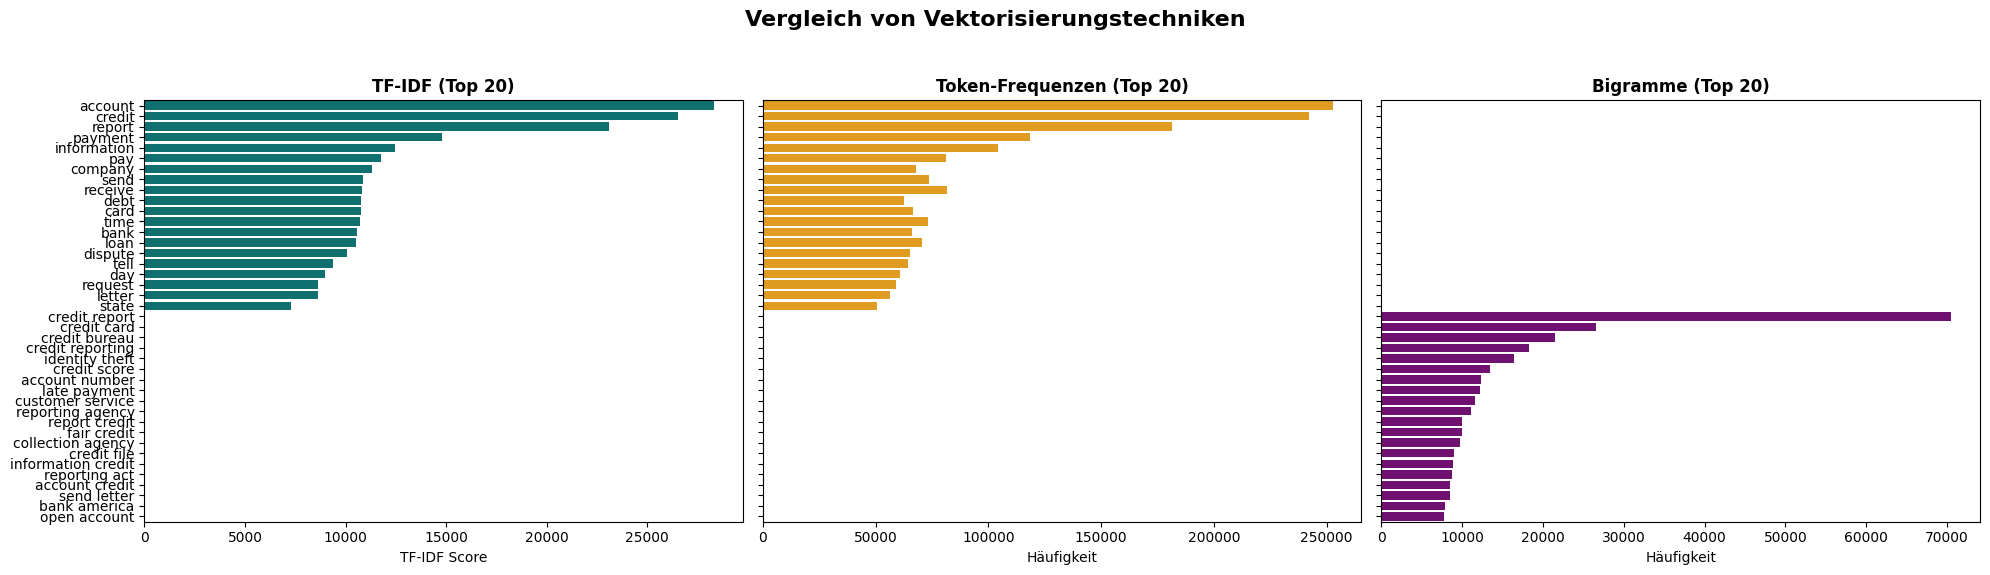


✅ Erklärung der Vektorisierungstechniken:
- TF-IDF: Hebt Wörter hervor, die in wenigen Dokumenten wichtig sind, dämpft sehr häufige Wörter.
- Token-Frequenzen: Zählt einfach, welche Wörter am häufigsten vorkommen.
- Bigramme: Betont Wortpaare, um wiederkehrende Phrasen und typische Begriffe zu identifizieren.


In [8]:
if 'df' in globals() and 'cleaned_text' in df.columns:
    # Texte als Liste einlesen
    docs = df['cleaned_text'].astype(str).tolist()

    # ============================================================
    # 1. TF-IDF-Vektorisierung
    # ============================================================
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, max_features=20)
    X_tfidf = tfidf_vectorizer.fit_transform(docs)
    tfidf_scores = X_tfidf.sum(axis=0).A1  # Summe pro Feature über alle Dokumente
    tfidf_df = pd.DataFrame({
        'Term': tfidf_vectorizer.get_feature_names_out(),
        'Score': tfidf_scores
    }).sort_values(by='Score', ascending=False)

    # ============================================================
    # 2. Token-Frequenzen
    # ============================================================
    all_tokens = ' '.join(docs).split()
    freq = Counter(all_tokens)
    token_df = pd.DataFrame(freq.most_common(20), columns=['Term', 'Score'])

    # ============================================================
    # 3. Bigramme
    # ============================================================
    cv_bigram = CountVectorizer(ngram_range=(2,2), min_df=5, max_features=20)
    X_bigram = cv_bigram.fit_transform(docs)
    bigram_scores = X_bigram.sum(axis=0).A1
    bigram_df = pd.DataFrame({
        'Term': cv_bigram.get_feature_names_out(),
        'Score': bigram_scores
    }).sort_values(by='Score', ascending=False)

    # ============================================================
    # 4. Plot: Alle drei Vektorisierungen nebeneinander
    # ============================================================
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    sns.barplot(data=tfidf_df, x='Score', y='Term', ax=axes[0], color='teal')
    axes[0].set_title('TF-IDF (Top 20)', fontsize=12, weight='bold')
    axes[0].set_xlabel('TF-IDF Score')
    axes[0].set_ylabel('')

    sns.barplot(data=token_df, x='Score', y='Term', ax=axes[1], color='orange')
    axes[1].set_title('Token-Frequenzen (Top 20)', fontsize=12, weight='bold')
    axes[1].set_xlabel('Häufigkeit')
    axes[1].set_ylabel('')

    sns.barplot(data=bigram_df, x='Score', y='Term', ax=axes[2], color='purple')
    axes[2].set_title('Bigramme (Top 20)', fontsize=12, weight='bold')
    axes[2].set_xlabel('Häufigkeit')
    axes[2].set_ylabel('')

    plt.suptitle('Vergleich von Vektorisierungstechniken', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # ============================================================
    # 5. Erklärung der Unterschiede
    # ============================================================
    print("\n✅ Erklärung der Vektorisierungstechniken:")
    print("- TF-IDF: Hebt Wörter hervor, die in wenigen Dokumenten wichtig sind, dämpft sehr häufige Wörter.")
    print("- Token-Frequenzen: Zählt einfach, welche Wörter am häufigsten vorkommen.")
    print("- Bigramme: Betont Wortpaare, um wiederkehrende Phrasen und typische Begriffe zu identifizieren.")

else:
    print("⚠️ DataFrame 'df' oder Spalte 'cleaned_text' wurde nicht gefunden.")


# 5) Themenmodellierung 

### a) LDA (mit CountVectorizer)

In [9]:
def display_topics(model, feature_names, no_top_words=15):
        topics = []
        for idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics.append((idx, top_features))
            print(f"\nTopic {idx}:\n", ', '.join(top_features))
        return topics

print("\n--- Themenmodellierung mit LDA (Latent Dirichlet Allocation) ---")

if 'df' in globals() and 'cleaned_text' in df.columns:
    
    # -------------------------------
    # 1. CountVectorizer erstellen
    # -------------------------------
    # Wandelt Text in numerische Bag-of-Words-Matrix um
    cv = CountVectorizer(
        max_df=0.95,       # Wörter ignorieren, die in >95% der Dokumente vorkommen
        min_df=5,          # Wörter ignorieren, die in <5 Dokumenten vorkommen
        max_features=5000  # maximal 5000 Merkmale (reduziert Speicherbedarf)
    )
    # Matrix erzeugen: Zeilen=Dokumente, Spalten=Wörter
    dtm = cv.fit_transform(df['cleaned_text'].astype(str))
    
    # -------------------------------
    # 2. LDA-Modell erstellen & trainieren
    # -------------------------------
    n_topics = 8 # gewünschte Anzahl der Themen
    lda = LatentDirichletAllocation(
        n_components=n_topics,  # Anzahl der Themen
        random_state=42,        # für Reproduzierbarkeit
        learning_method='batch' # Batch-Algorithmus für LDA
    )
    lda.fit(dtm)  # Training auf der Dokument-Term-Matrix

    # -------------------------------
    # 3. Feature-Namen aus CountVectorizer
    # -------------------------------
    feature_names = cv.get_feature_names_out()  # Liste aller Wörter/Features

    # -------------------------------
    # 4. Top-Wörter pro Thema anzeigen
    # -------------------------------
    lda_topics = display_topics(lda, feature_names, no_top_words=15)
    # lda_topics enthält jetzt [(Thema-Index, [Top-Wörter]), ...]


--- Themenmodellierung mit LDA (Latent Dirichlet Allocation) ---

Topic 0:
 payment, loan, pay, mortgage, time, tell, month, company, receive, home, ask, day, year, state, send

Topic 1:
 account, letter, send, information, receive, number, request, dispute, provide, verify, document, address, state, response, mail

Topic 2:
 credit, report, account, information, bureau, late, remove, payment, score, dispute, day, reporting, inaccurate, time, delete

Topic 3:
 credit, report, inquiry, account, remove, information, identity, experian, equifax, date, theft, file, fraudulent, bankruptcy, company

Topic 4:
 bank, account, card, tell, check, money, receive, time, day, phone, send, try, ask, service, customer

Topic 5:
 information, consumer, account, report, credit, reporting, section, agency, act, dispute, fcra, fair, file, furnisher, identity

Topic 6:
 debt, collection, company, credit, owe, provide, send, state, claim, letter, request, agency, receive, original, report

Topic 7:
 accou

### b) NMF (mit TfidfVectorizer)

In [10]:
print("\n--- Themenmodellierung mit NMF (Non-negative Matrix Factorization) ---")

if 'df' in globals() and 'cleaned_text' in df.columns:

    # -------------------------------
    # 1. TF-IDF-Vektorisierung
    # -------------------------------
    # NMF arbeitet besser mit gewichteten Textdaten (TF-IDF) als mit reinen Wortzählungen

    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.95,       # ignoriere Wörter, die in mehr als 95% der Dokumente vorkommen
        min_df=5,          # ignoriere Wörter, die in weniger als 5 Dokumenten vorkommen
        max_features=5000  # maximal 5000 Features zur Reduktion der Dimensionalität
    )

    # TF-IDF-Matrix erstellen: Zeilen = Dokumente, Spalten = Wörter
    tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

    # -------------------------------
    # 2. NMF-Modell erstellen & trainieren
    # -------------------------------
    n_topics = 8  # Anzahl der Themen, die extrahiert werden sollen
    nmf = NMF(
        n_components=n_topics,  # Anzahl der zu findenden Themen
        random_state=42         # für Reproduzierbarkeit
    )

    # Training des NMF-Modells auf der TF-IDF-Matrix
    nmf.fit(tfidf)

    # -------------------------------
    # 3. Feature-Namen extrahieren
    # -------------------------------
    # Listet alle Wörter/Features der TF-IDF-Matrix auf
    feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

    # -------------------------------
    # 4. Top-Wörter pro Thema anzeigen
    # -------------------------------
    # Nutzt die vorher definierte Funktion display_topics
    # Gibt pro Thema die 15 wichtigsten Wörter aus
    nmf_topics = display_topics(nmf, feature_names_tfidf, no_top_words=15)
    # nmf_topics enthält: [(Thema-Index, [Liste der Top-Wörter]), ...]



--- Themenmodellierung mit NMF (Non-negative Matrix Factorization) ---

Topic 0:
 report, credit, information, dispute, bureau, remove, experian, inaccurate, item, reporting, equifax, letter, delete, file, transunion

Topic 1:
 card, bank, charge, money, tell, check, receive, chase, credit, send, time, use, transaction, day, phone

Topic 2:
 account, open, balance, close, remove, fraudulent, collection, number, belong, date, acct, closed, creditor, report, status

Topic 3:
 payment, late, pay, month, fee, balance, day, time, report, date, monthly, miss, history, statement, credit

Topic 4:
 inquiry, credit, hard, authorize, report, unauthorized, date, remove, add, company, pull, authorization, initiate, knowledge, inquire

Topic 5:
 debt, collection, company, owe, letter, agency, send, validation, collect, receive, original, provide, pay, request, creditor

Topic 6:
 loan, mortgage, pay, company, home, tell, refinance, student, forbearance, time, rate, interest, month, year, email

To

### c) Vergleich LDA vs. NMF - Kohärenzbewertung & Analyse

In [11]:
print("\n--- Vergleich von LDA und NMF: Modellgüte ---")

# Vorbereitung für Gensim-Coherence-Berechnung
texts_tokenized = [t.split() for t in df['cleaned_text']]
id2word = corpora.Dictionary(texts_tokenized)
corpus = [id2word.doc2bow(text) for text in texts_tokenized]

# Gensim-LDA (zur Kohärenzbewertung, nicht identisch mit sklearn-LDA)
lda_gensim = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=n_topics,
    random_state=42,
    passes=5,
    chunksize=1000,
    update_every=1,
    alpha='auto',
    per_word_topics=True
)

# Kohärenz für LDA
coherence_lda = CoherenceModel(model=lda_gensim, texts=texts_tokenized, dictionary=id2word, coherence='c_v')
coh_lda = coherence_lda.get_coherence()

# Kohärenz für NMF (Gensim erwartet ebenfalls Topics als Listen)
nmf_topic_words = [topic[1] for topic in nmf_topics]
coherence_nmf = CoherenceModel(topics=nmf_topic_words, texts=texts_tokenized, dictionary=id2word, coherence='c_v')
coh_nmf = coherence_nmf.get_coherence()

print(f"\nCoherence Score LDA  : {coh_lda:.4f}")
print(f"Coherence Score NMF  : {coh_nmf:.4f}")


--- Vergleich von LDA und NMF: Modellgüte ---

Coherence Score LDA  : 0.4949
Coherence Score NMF  : 0.5063


### d) Visualisierung der Kohärenzwerte (LDA vs. NMF)

+----------+-----------------------------------+-----------------+------------------+------------------------------------------------------------+
| Modell   | Algorithmus                       | Eingabematrix   |   Kohärenz (c_v) | Interpretation                                             |
+==========+===================================+=================+==================+============================================================+
| LDA      | Latent Dirichlet Allocation       | CountVectorizer |         0.494894 | breite, überlappende Themen – gut für explorative Analysen |
+----------+-----------------------------------+-----------------+------------------+------------------------------------------------------------+
| NMF      | Non-negative Matrix Factorization | TF-IDF          |         0.506271 | schärfer getrennte Themen – gut für klare Kategorisierung  |
+----------+-----------------------------------+-----------------+------------------+---------------------------------

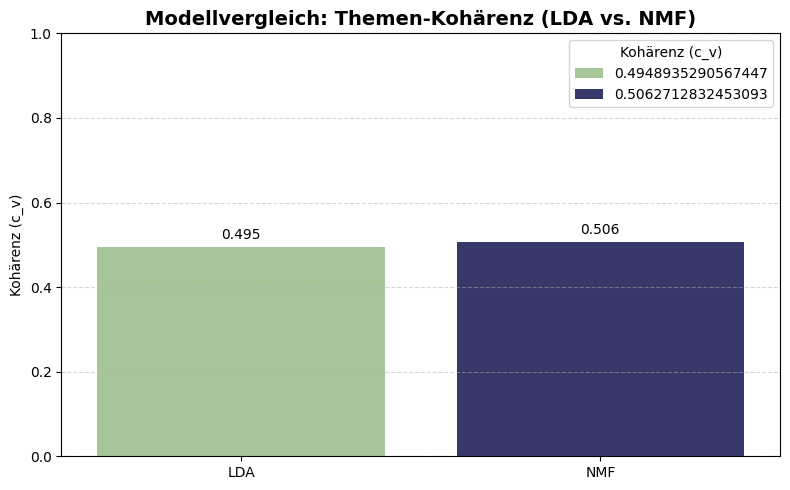

In [12]:
# DataFrame mit Vergleichsinformationen erstellen
comparison_df = pd.DataFrame({
    'Modell': ['LDA', 'NMF'],
    'Algorithmus': ['Latent Dirichlet Allocation', 'Non-negative Matrix Factorization'],
    'Eingabematrix': ['CountVectorizer', 'TF-IDF'],
    'Kohärenz (c_v)': [coh_lda, coh_nmf],
    'Interpretation': [
        'breite, überlappende Themen – gut für explorative Analysen',
        'schärfer getrennte Themen – gut für klare Kategorisierung'
    ]
})

# ------------------------------------------------------------
# 1. Vollständige Ausgabe des DataFrames inkl. Interpretation
# ------------------------------------------------------------
# Sicherstellen, dass die Spalteninhalte vollständig angezeigt werden
pd.set_option('display.max_colwidth', None)  # Keine Kürzung von Text in Spalten

# DataFrame ausgeben
print(tabulate(comparison_df, headers='keys', tablefmt='grid', showindex=False))

# ------------------------------------------------------------
# 2. Visualisierung der Kohärenzwerte
# ------------------------------------------------------------
plt.figure(figsize=(8, 5))

sns.barplot(
    x='Modell', 
    y='Kohärenz (c_v)', 
    data=comparison_df, 
    hue='Kohärenz (c_v)', 
    palette='crest'
)

# Titel und Achsenbeschriftung
plt.title('Modellvergleich: Themen-Kohärenz (LDA vs. NMF)', fontsize=14, weight='bold')
plt.ylabel('Kohärenz (c_v)')
plt.xlabel('')

# Y-Achse fixieren
plt.ylim(0, 1)

# Werte über den Balken anzeigen
for i, v in enumerate(comparison_df['Kohärenz (c_v)']):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)

# Gitternetzlinien für bessere Lesbarkeit
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 6) Visualisierung der Top-Wörter pro Thema

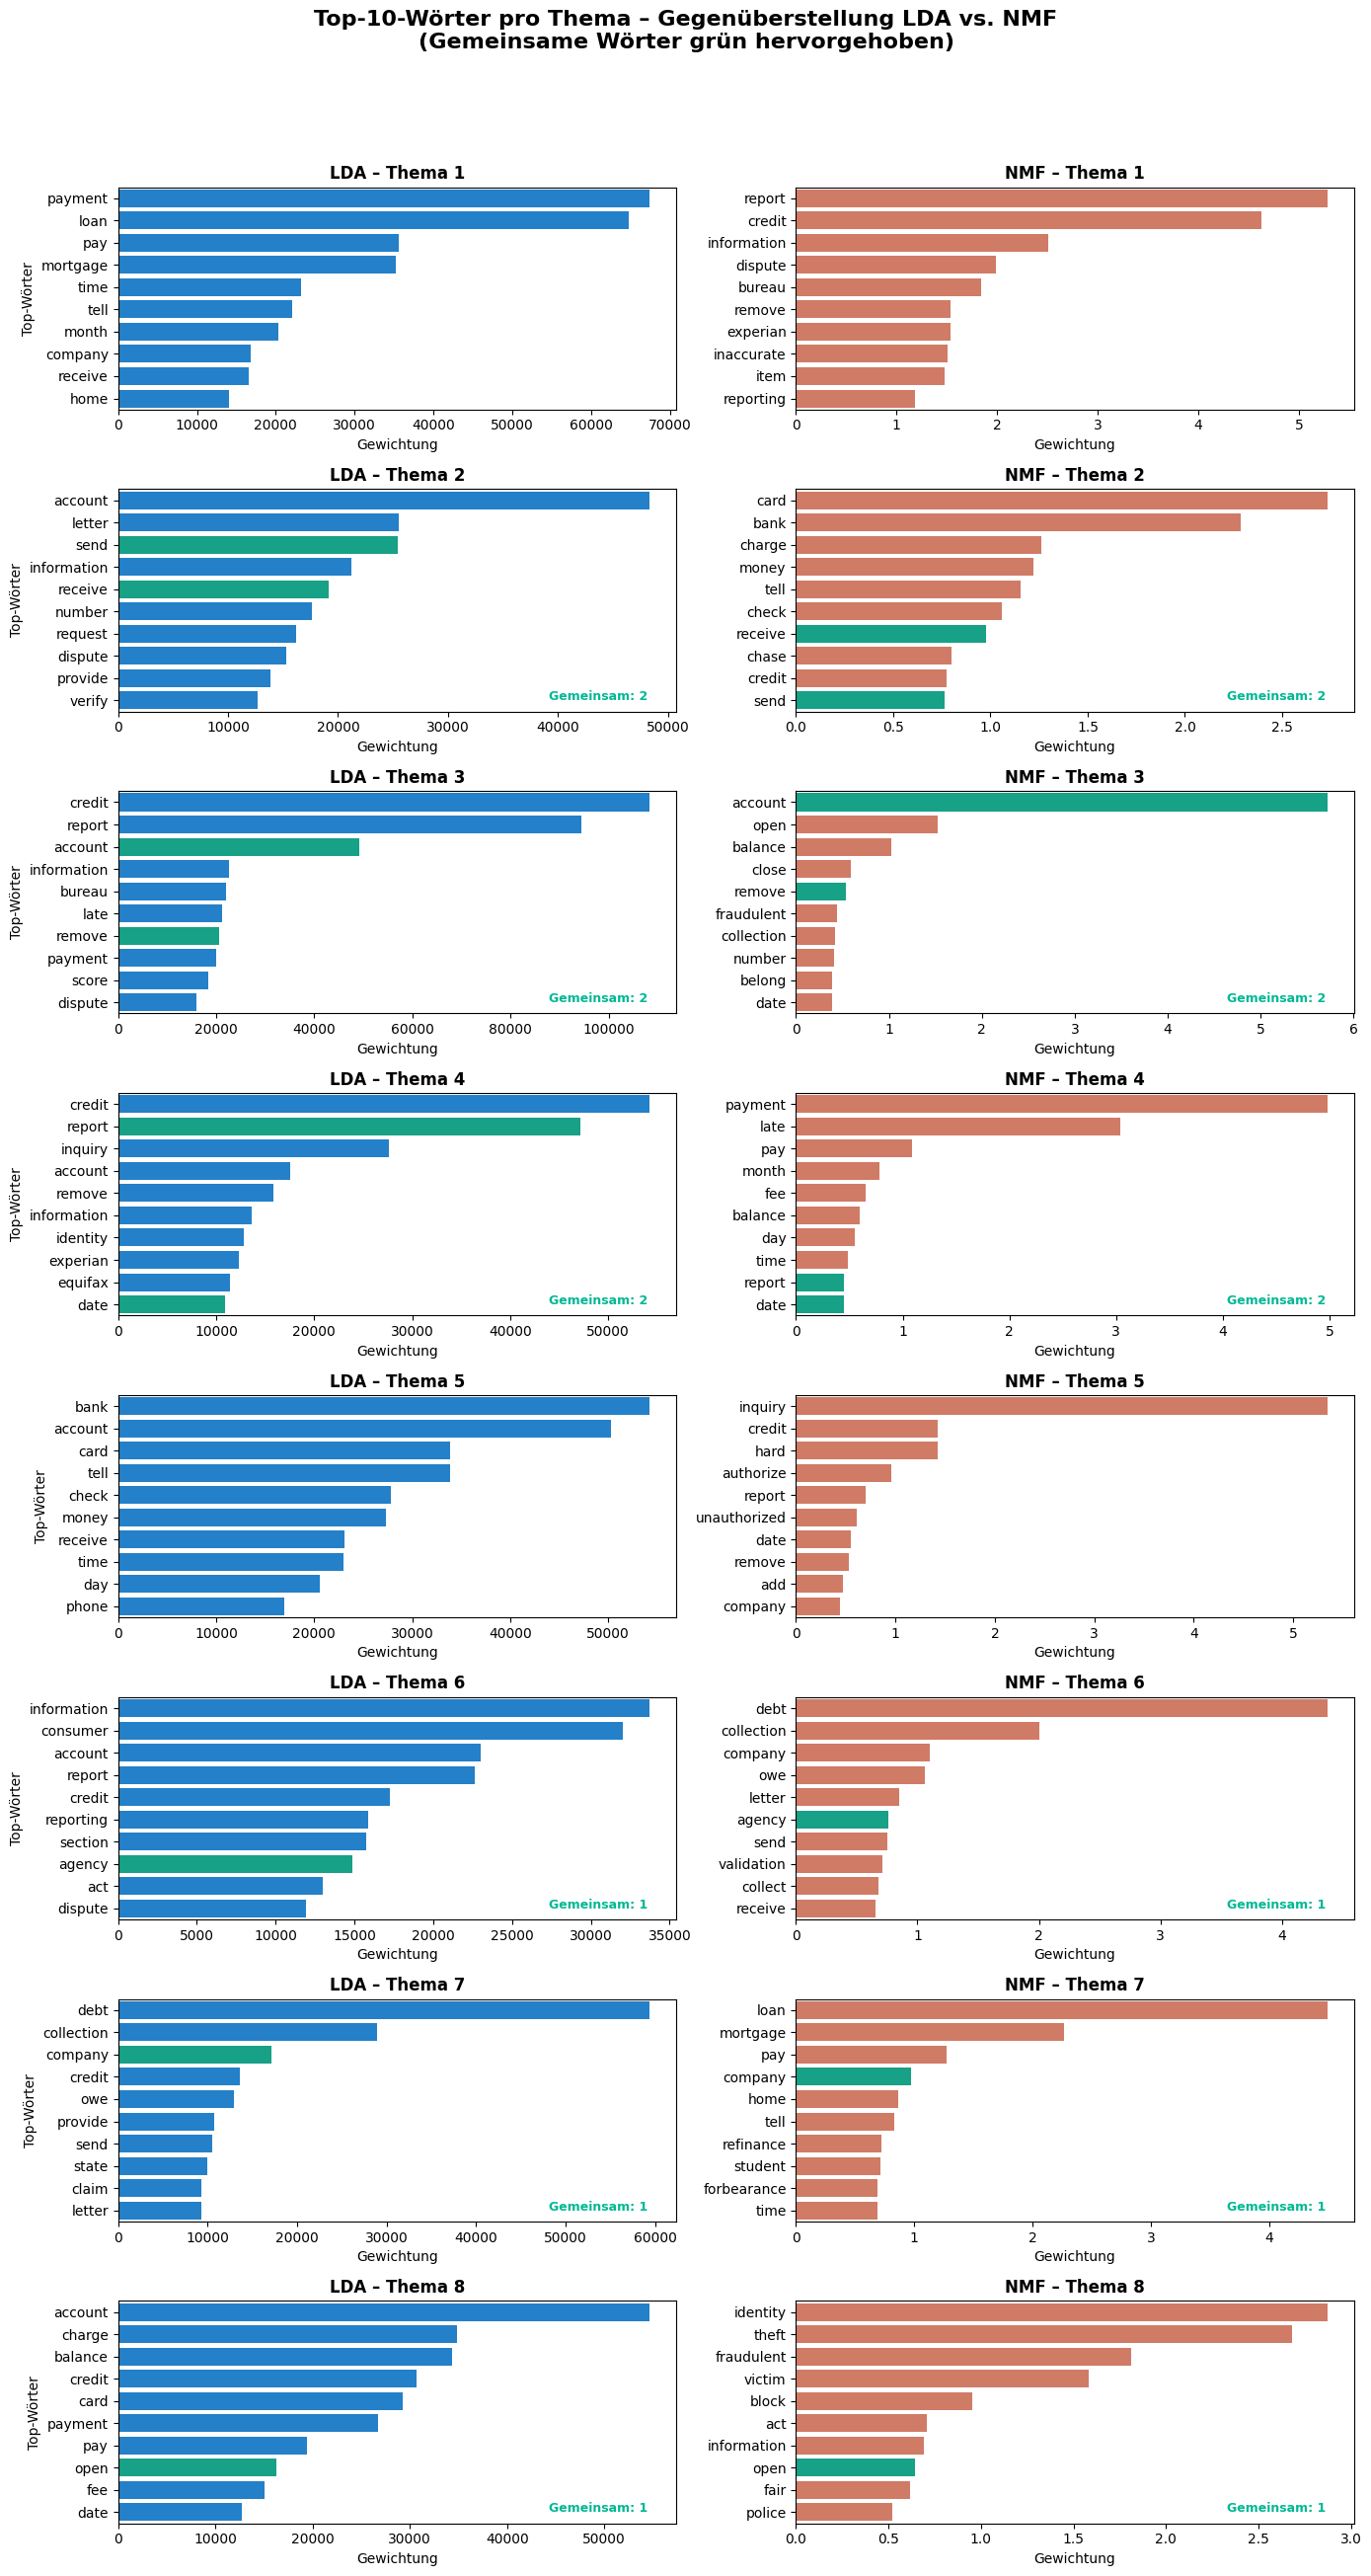

In [13]:
def plot_topics_side_by_side_highlight(lda_model, nmf_model, lda_features, nmf_features, n_top_words=10):
    """
    Zeigt LDA- und NMF-Themen nebeneinander, gemeinsame Wörter grün hervorgehoben.
    Zukunftssicher (Seaborn >= 0.13).
    """
    n_topics = lda_model.n_components
    fig, axes = plt.subplots(n_topics, 2, figsize=(14, n_topics * 3.5), sharex=False)
    if n_topics == 1:
        axes = np.array([[axes[0], axes[1]]]) if axes.ndim == 1 else axes.reshape(1, 2)

    for i in range(n_topics):
        # Top-Wörter extrahieren
        lda_idx = lda_model.components_[i].argsort()[:-n_top_words - 1:-1]
        nmf_idx = nmf_model.components_[i].argsort()[:-n_top_words - 1:-1]

        lda_words = [lda_features[j] for j in lda_idx]
        nmf_words = [nmf_features[j] for j in nmf_idx]

        lda_weights = lda_model.components_[i][lda_idx]
        nmf_weights = nmf_model.components_[i][nmf_idx]

        # Gemeinsame Wörter
        common = set(lda_words) & set(nmf_words)

        # DataFrames für Plot
        lda_df = pd.DataFrame({
            "word": lda_words,
            "weight": lda_weights,
            "is_common": ["gemeinsam" if w in common else "einzigartig" for w in lda_words]
        })
        nmf_df = pd.DataFrame({
            "word": nmf_words,
            "weight": nmf_weights,
            "is_common": ["gemeinsam" if w in common else "einzigartig" for w in nmf_words]
        })

        # Farben definieren (grün für gemeinsame Wörter)
        lda_palette = {"gemeinsam": "#00b894", "einzigartig": "#0984e3"}
        nmf_palette = {"gemeinsam": "#00b894", "einzigartig": "#e17055"}

        # LDA-Plot
        sns.barplot(
            data=lda_df, x="weight", y="word", hue="is_common",
            palette=lda_palette, dodge=False, legend=False, ax=axes[i, 0]
        )
        axes[i, 0].set_title(f"LDA – Thema {i+1}", fontsize=12, weight="bold")
        axes[i, 0].set_xlabel("Gewichtung")
        axes[i, 0].set_ylabel("Top-Wörter")

        # NMF-Plot
        sns.barplot(
            data=nmf_df, x="weight", y="word", hue="is_common",
            palette=nmf_palette, dodge=False, legend=False, ax=axes[i, 1]
        )
        axes[i, 1].set_title(f"NMF – Thema {i+1}", fontsize=12, weight="bold")
        axes[i, 1].set_xlabel("Gewichtung")
        axes[i, 1].set_ylabel("")

        # Textinfo: gemeinsame Wörter
        if common:
            axes[i, 0].text(0.95, 0.05, f"Gemeinsam: {len(common)}",
                            transform=axes[i, 0].transAxes, ha='right', fontsize=9, color='#00b894', weight='bold')
            axes[i, 1].text(0.95, 0.05, f"Gemeinsam: {len(common)}",
                            transform=axes[i, 1].transAxes, ha='right', fontsize=9, color='#00b894', weight='bold')

    fig.suptitle(
        "Top-10-Wörter pro Thema – Gegenüberstellung LDA vs. NMF\n(Gemeinsame Wörter grün hervorgehoben)",
        fontsize=16, weight="bold"
    )
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


# Aufruf:
plot_topics_side_by_side_highlight(
    lda_model=lda,
    nmf_model=nmf,
    lda_features=cv.get_feature_names_out(),
    nmf_features=tfidf_vectorizer.get_feature_names_out(),
    n_top_words=10
)

# 7) Auswertung der Top-Themen

In [14]:
# Top-Wörter pro Thema (LDA)
n_top_words = 10
topics_summary = []
for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [cv.get_feature_names_out()[i] for i in top_indices]
    topics_summary.append((topic_idx + 1, top_features))

In [15]:
# Optional: Kurze Beschreibung zu jedem Thema
topic_descriptions = {
    1: "Kreditkarten, Zinsen, Gebühren – Beschwerden zu Kreditkartenkonten und unerwarteten Kosten",
    2: "Hypotheken, Zahlungen, Darlehen – Probleme bei Hypothekenzahlungen oder Kreditvergabe",
    3: "Identitätsdiebstahl, Betrug, Kontosicherheit – Fälle von Betrug und unautorisierten Transaktionen",
    4: "Bankkonten, Überweisungen, Gebühren – Beschwerden zu Bankkonten und Transaktionsgebühren",
    5: "Versicherungen, Ansprüche, Zahlungen – Verzögerungen oder Ablehnungen bei Versicherungsleistungen",
    6: "Kundendienst, Kommunikation, Support – Probleme mit Kundenservice und Support",
    7: "Schulden, Inkasso, Rückzahlungen – Beschwerden über Inkassounternehmen oder Schuldenmanagement",
    8: "Sonstige Finanzprodukte – Themen, die in die vorherigen Kategorien nicht passen"
}

# Ausgabe der Beschreibungen zusammen mit Top-Wörtern
for topic_num, words in topics_summary:
    print(f"\n--- Thema {topic_num} ---")
    print("Top-Wörter:", ", ".join(words))
    print("Beschreibung:", topic_descriptions.get(topic_num, "Keine Beschreibung verfügbar"))



--- Thema 1 ---
Top-Wörter: payment, loan, pay, mortgage, time, tell, month, company, receive, home
Beschreibung: Kreditkarten, Zinsen, Gebühren – Beschwerden zu Kreditkartenkonten und unerwarteten Kosten

--- Thema 2 ---
Top-Wörter: account, letter, send, information, receive, number, request, dispute, provide, verify
Beschreibung: Hypotheken, Zahlungen, Darlehen – Probleme bei Hypothekenzahlungen oder Kreditvergabe

--- Thema 3 ---
Top-Wörter: credit, report, account, information, bureau, late, remove, payment, score, dispute
Beschreibung: Identitätsdiebstahl, Betrug, Kontosicherheit – Fälle von Betrug und unautorisierten Transaktionen

--- Thema 4 ---
Top-Wörter: credit, report, inquiry, account, remove, information, identity, experian, equifax, date
Beschreibung: Bankkonten, Überweisungen, Gebühren – Beschwerden zu Bankkonten und Transaktionsgebühren

--- Thema 5 ---
Top-Wörter: bank, account, card, tell, check, money, receive, time, day, phone
Beschreibung: Versicherungen, Ansprü

# 8) Zusammenfassung der häufigsten Themen

   Thema  Anzahl Beschwerden
0      1               23723
1      2               10324
2      3               20729
3      4               16278
4      5               27826
5      6                4319
6      7               13856
7      8                7417


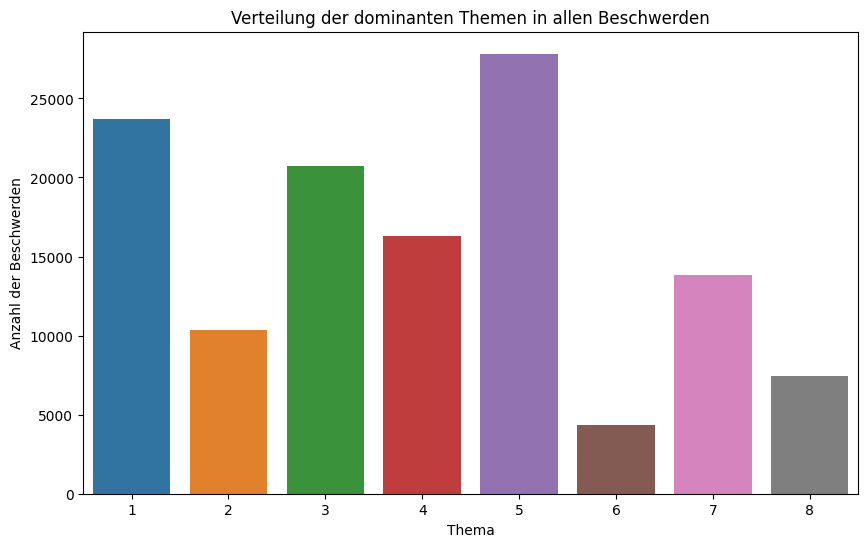

In [16]:
if 'df' in globals() and 'cleaned_text' in df.columns:
    # Dominantes Thema pro Dokument (höchster LDA-Score)
    doc_topic_dist = lda.transform(dtm)
    df['dominant_topic'] = doc_topic_dist.argmax(axis=1) + 1 # +1, um 1-basiert zu sein


    # Zähle Anzahl der Dokumente pro Thema
    topic_counts = df['dominant_topic'].value_counts().sort_index()
    summary_df = pd.DataFrame({
    'Thema': topic_counts.index,
    'Anzahl Beschwerden': topic_counts.values
    })
    print(summary_df)

    plt.figure(figsize=(10,6))
    sns.barplot(x='Thema', y='Anzahl Beschwerden', data=summary_df, 
            hue='Thema', palette='tab10', dodge=False, legend=False)

    plt.title('Verteilung der dominanten Themen in allen Beschwerden')
    plt.xlabel('Thema')
    plt.ylabel('Anzahl der Beschwerden')
    plt.show()

# Schlussfolgerung & Interpretation

Die thematische Analyse der CFPB-Beschwerden mittels NLP ermöglicht einen systematischen Überblick über häufige Verbraucherprobleme in Finanzdienstleistungen.

### Zentrale Erkenntnisse:

Häufige Themen betreffen 

- Kreditkarten, 
- Zinsen und Gebühren, 
- Hypotheken und Rückzahlungen, 
- Identitätsdiebstahl

sowie Kundendienstprobleme.

**LDA-Modell** (Latent Dirichlet Allocation) liefert eher breite, überlappende Themen. Es eignet sich gut für explorative Analysen, bei denen die inhaltlichen Zusammenhänge zwischen Themen sichtbar bleiben.

**NMF-Modell** (Non-negative Matrix Factorization) erzeugt klarer getrennte Themencluster. In Kombination mit TF-IDF-Vektorisierung liefert es die interpretierbarsten Ergebnisse für eine gezielte Kategorisierung.

**TF-IDF vs. CountVectorizer:** TF-IDF hebt seltenere, relevante Begriffe stärker hervor, während die einfache Wortzählung (CountVectorizer) häufige Wörter dominant macht. Für NMF sind gewichtete Eingabematrizen oft vorteilhafter.

### Fazit:
Beide Ansätze ermöglichen die Identifikation zentraler Themen in den Beschwerden. Die Methodik liefert damit eine fundierte Datengrundlage für strategische Entscheidungen im Verbraucherschutz. Insbesondere die Kombination aus TF-IDF + NMF zeigt sich als besonders interpretierbar und praxisnah einsetzbar.

### Ausblick:
Die gleiche Pipeline kann auf andere textbasierte Beschwerde- oder Feedbacksysteme übertragen werden, um datengetriebene Entscheidungen zu unterstützen, z. B. zur Optimierung von Serviceleistungen oder zur frühzeitigen Erkennung wiederkehrender Probleme.